# Interpretable Modelling of Credit Risk

As detailed in Cynthia Rudin's excellent commentary on interpretability [(ArXiV version here)](https://arxiv.org/abs/1811.10154), there are a plethora of reasons to avoid the use of black box models when models are being used to make high stakes decisions to may have life-altering effects on real people. Efforts to develop "explainable black box models," while appealing for their potential to let us continuing using the same tools we always have and to creation explanations after the fact, are inherently flawed. As Rudin notes in my single favorite passage from her paper:

> Explainable ML methods provide explanations that are not faithful to what the original model computes. Explanations must be wrong. They cannot have perfect fidelity with respect to the original model. If the explanation was completely faithful to what the original model computes, the explanation would equal the original model, and one would not need the original model in the first place, only the explanation. (In other words, this is a case where the original model would be interpretable.) This leads to the danger that any explanation method for a black box model can be an inaccurate representation of the original model in parts of the feature space.
>
> An inaccurate (low-fidelity) explanation model limits trust in the explanation, and by extension, trust in the black box that it is trying to explain. An explainable model that has a 90% agreement with the original model indeed explains the original model most of the time. However, an explanation model that is correct 90% of the time is wrong 10% of the time. If a tenth of the explanations are incorrect, one cannot trust the explanations, and thus one cannot trust the original black box. If we cannot know for certain whether our explanation is correct, we cannot know whether to trust either the explanation or the original model.

With this motivation in mind, in this exercise, we will use a cutting edge interpretable modeling framework to model credit risk using data from the [14th Pacific-Asia Knowledge Discovery and Data Mining conference (PAKDD 2010)](https://pakdd.org/archive/pakdd2010/). This data covers the period of 2006 to 2009, and "comes from a private label credit card operation of a Brazilian credit company and its partner shops." (The competition was won by [TIMi](https://timi.eu/blog/news/timi-top-winner-at-the-pakdd-2010-cup/), who purely by coincidence helped me complete my PhD dissertation research!).

We will be working with Generalized Additive Models (GAMs) (not to be confused with Generalized *Linear* Models (GLMs) — GLMs are a special case of GAMs). In particular, we will be using the [pyGAM](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html), though this is far from the only GAM implementation out there. [mvgam](https://nicholasjclark.github.io/mvgam/) in R is probably considered the gold standard, as it was developed by a pioneering researcher of GAMs. `statsmodels` also has [an implementation](https://www.statsmodels.org/stable/gam.html), and GAM is also hiding in plain sight behind many other tools, like Meta's [Prophet](https://facebook.github.io/prophet/) time series forecasting library (which is GAM-based).

In [34]:
# import xlrd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from pygam import LogisticGAM, s, f
from pygam.datasets import default
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import warnings

warnings.filterwarnings("ignore")

## Data Prep

### Exercise 1

The PADD 2010 data is in [this repository](https://github.com/nickeubank/MIDS_Data/tree/master/PAKDD%202010). You can find column names in `PAKDD2010_VariablesList.XLS` and the actual data in `PAKDD2010_Modeling_Data.txt`.

Note: you may run into a string-encoding issue loading the `PAKDD2010_Modeling_Data.txt` data. All I'll say is that most latin-based languages used `latin8` as a text encoding prior to broad adoption of UTF-8. (Don't know about UTF? [Check out this video](https://www.youtube.com/watch?v=MijmeoH9LT4)!)

Load the data (including column names).

In [35]:
# column names
columns_file_path = "https://raw.githubusercontent.com/nickeubank/MIDS_Data/master/PAKDD%202010/PAKDD2010_VariablesList.XLS"
df_columns = pd.read_excel(columns_file_path, header=None)
column_names = df_columns[1].tolist()

In [36]:
# find duplicate
for i in range(len(column_names)):
    if column_names[i] in column_names[:i]:
        print(column_names[i])

# Two EDUCATION_LEVEL
# Keep the first one to be EDUCATION_LEVEL
# Change the seconde one to MATE_EDUCATION_LEVEL

second_edu_level_idx = [
    i for i, value in enumerate(column_names) if value == "EDUCATION_LEVEL"
][-1]

column_names[second_edu_level_idx] = "MATE_EDUCATION_LEVEL"

EDUCATION_LEVEL


In [37]:
# data
data_file_path = "https://media.githubusercontent.com/media/nickeubank/MIDS_Data/master/PAKDD%202010/PAKDD2010_Modeling_Data.txt"
df_data = pd.read_csv(
    data_file_path, encoding="latin1", sep="\t", header=None, names=column_names[1:]
)

In [38]:
df_data.head()

,ID_CLIENT,CLERK_TYPE,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL,...,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,FLAG_ACSP_RECORD,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD=1
0,1,C,5,Web,0,1,F,6,1,0,...,0,0,0,0,1,N,32,595,595,1
1,2,C,15,Carga,0,1,F,2,0,0,...,0,0,0,0,1,N,34,230,230,1
2,3,C,5,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,27,591,591,0
3,4,C,20,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,61,545,545,0
4,5,C,10,Web,0,1,M,2,0,0,...,0,0,0,0,1,N,48,235,235,1


In [39]:
df_columns

,0,1,2,3
0,Var_Id,Var_Title,Var_Description,Field_Content
1,1,ID_CLIENT,Sequential number for the applicant (to be use...,"1-50000, 50001-70000, 70001-90000"
2,2,CLERK_TYPE,Not informed,C
3,3,PAYMENT_DAY,"Day of the month for bill payment, chosen by t...","1,5,10,15,20,25"
4,4,APPLICATION_SUBMISSION_TYPE,Indicates if the application was submitted via...,"Web, Carga"
5,5,QUANT_ADDITIONAL_CARDS,Quantity of additional cards asked for in the ...,"1,2,NULL"
6,6,POSTAL_ADDRESS_TYPE,Indicates if the address for posting is the ho...,1.2
7,7,SEX,NaN,"M=Male, F=Female"
8,8,MARITAL_STATUS,Encoding not informed,"1,2,3,4,5,6,7"
9,9,QUANT_DEPENDANTS,NaN,"0, 1, 2, ..."


### Exercise 2

There are a few variables with a lot of missing values (more than half missing). Given the limited documentation for this data it's a little hard to be sure why, but given the effect on sample size and what variables are missing, let's go ahead and drop them. You you end up dropping 6 variables.

Hint: Some variables have missing values that aren't immediately obviously.

(This is not strictly necessary at this stage, given we'll be doing more feature selection down the line, but keeps things easier knowing we don't have to worry about missingness later.)

In [40]:
df_data.describe()

,ID_CLIENT,PAYMENT_DAY,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL,NACIONALITY,RESIDENCE_TYPE,MONTHS_IN_RESIDENCE,...,OCCUPATION_TYPE,MATE_PROFESSION_CODE,MATE_EDUCATION_LEVEL,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,AGE,TARGET_LABEL_BAD=1
count,50000.000000,50000.000000,50000.0,50000.000000,50000.00000,50000.000000,50000.0,50000.000000,48651.000000,46223.000000,...,42687.000000,21116.000000,17662.000000,50000.0,50000.0,50000.0,50000.0,50000.000000,50000.00000,50000.000000
mean,25000.500000,12.869920,0.0,1.006540,2.14840,0.650520,0.0,0.961600,1.252225,9.727149,...,2.484316,3.797926,0.296003,0.0,0.0,0.0,0.0,1.275700,43.24852,0.260820
std,14433.901067,6.608385,0.0,0.080606,1.32285,1.193655,0.0,0.202105,0.867833,10.668841,...,1.532261,5.212168,0.955688,0.0,0.0,0.0,0.0,0.988286,14.98905,0.439086
min,1.000000,1.000000,0.0,1.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,6.00000,0.000000
25%,12500.750000,10.000000,0.0,1.000000,1.00000,0.000000,0.0,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,31.00000,0.000000
50%,25000.500000,10.000000,0.0,1.000000,2.00000,0.000000,0.0,1.000000,1.000000,6.000000,...,2.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,41.00000,0.000000
75%,37500.250000,15.000000,0.0,1.000000,2.00000,1.000000,0.0,1.000000,1.000000,15.000000,...,4.000000,11.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,53.00000,1.000000
max,50000.000000,25.000000,0.0,2.000000,7.00000,53.000000,0.0,2.000000,5.000000,228.000000,...,5.000000,17.000000,5.000000,0.0,0.0,0.0,0.0,7.000000,106.00000,1.000000


In [41]:
df_data["APPLICATION_SUBMISSION_TYPE"] = df_data["APPLICATION_SUBMISSION_TYPE"].replace(
    "0", np.nan
)
df_data["SEX"] = df_data["SEX"].replace(["N", " "], np.nan)
df_data["MARITAL_STATUS"] = df_data["MARITAL_STATUS"].replace(0, np.nan)
df_data["OCCUPATION_TYPE"] = df_data["OCCUPATION_TYPE"].replace(0.0, np.nan)
df_data["RESIDENCE_TYPE"] = df_data["RESIDENCE_TYPE"].replace(0.0, np.nan)
df_data["RESIDENCIAL_ZIP_3"] = df_data["RESIDENCIAL_ZIP_3"].replace("#DIV/0!", np.nan)
df_data["PROFESSIONAL_STATE"] = df_data["PROFESSIONAL_STATE"].replace(" ", np.nan)
df_data["PROFESSIONAL_PHONE_AREA_CODE"] = df_data[
    "PROFESSIONAL_PHONE_AREA_CODE"
].replace(" ", np.nan)

In [42]:
df_data.isna().sum().sort_values(ascending=False)

PROFESSIONAL_PHONE_AREA_CODE      36532
PROFESSIONAL_STATE                34307
PROFESSIONAL_CITY                 33783
PROFESSIONAL_BOROUGH              33783
MATE_EDUCATION_LEVEL              32338
MATE_PROFESSION_CODE              28884
APPLICATION_SUBMISSION_TYPE       19461
OCCUPATION_TYPE                   10101
PROFESSION_CODE                    7756
MONTHS_IN_RESIDENCE                3777
RESIDENCE_TYPE                     2109
MARITAL_STATUS                      202
SEX                                  65
RESIDENCIAL_ZIP_3                     1
COMPANY                               0
FLAG_PROFESSIONAL_PHONE               0
QUANT_CARS                            0
MONTHS_IN_THE_JOB                     0
ID_CLIENT                             0
QUANT_SPECIAL_BANKING_ACCOUNTS        0
FLAG_HOME_ADDRESS_DOCUMENT            0
FLAG_RG                               0
FLAG_CPF                              0
FLAG_INCOME_PROOF                     0
PRODUCT                               0


In [43]:
missing = df_data.isna().mean()
missing_50_col = list(missing[missing > 0.5].index)

missing_50_col

['PROFESSIONAL_STATE',
 'PROFESSIONAL_CITY',
 'PROFESSIONAL_BOROUGH',
 'PROFESSIONAL_PHONE_AREA_CODE',
 'MATE_PROFESSION_CODE',
 'MATE_EDUCATION_LEVEL']

In [44]:
# drop
df1 = df_data.drop(columns=missing_50_col)

df1

,ID_CLIENT,CLERK_TYPE,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL,...,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,FLAG_ACSP_RECORD,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD=1
0,1,C,5,Web,0,1,F,6.0,1,0,...,0,0,0,0,1,N,32,595,595,1
1,2,C,15,Carga,0,1,F,2.0,0,0,...,0,0,0,0,1,N,34,230,230,1
2,3,C,5,Web,0,1,F,2.0,0,0,...,0,0,0,0,1,N,27,591,591,0
3,4,C,20,Web,0,1,F,2.0,0,0,...,0,0,0,0,1,N,61,545,545,0
4,5,C,10,Web,0,1,M,2.0,0,0,...,0,0,0,0,1,N,48,235,235,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49996,C,10,NaN,0,1,F,1.0,2,0,...,0,0,0,0,1,N,36,591,591,1
49996,49997,C,25,NaN,0,1,F,1.0,0,0,...,0,0,0,0,2,N,21,186,186,0
49997,49998,C,5,Web,0,1,M,2.0,3,0,...,0,0,0,0,1,N,41,715,715,0
49998,49999,C,1,Web,0,1,F,1.0,1,0,...,0,0,0,0,1,N,28,320,320,1


### Exercise 3

Let's start off by fitting a model that uses the following variables:

```
"QUANT_DEPENDANTS",
"QUANT_CARS",
"MONTHS_IN_RESIDENCE",
"PERSONAL_MONTHLY_INCOME",
"QUANT_BANKING_ACCOUNTS",
"AGE",
"SEX",
"MARITAL_STATUS",
"OCCUPATION_TYPE",
"RESIDENCE_TYPE",
"RESIDENCIAL_STATE",
"RESIDENCIAL_CITY",
"RESIDENCIAL_BOROUGH",
"RESIDENCIAL_ZIP_3"
```

(GAMs don't have any automatic feature selection methods, so these are based on my own sense of features that are likely to matter. A fully analysis would entail a few passes at feature refinement)

Plot and otherwise characterize the distributions of all the variables we may use. If you see anything bananas, adjust how terms enter your model. Yes, pyGAM has flexible functional forms, but giving the model features that are engineered to be more substantively meaningful (e.g., taking log of income) will aid model estimation. 

You should probably do something about the functional form of *at least* `PERSONAL_MONTHLY_INCOME`, and `QUANT_DEPENDANTS`.

In [45]:
df1 = df1[
    [
        "QUANT_DEPENDANTS",
        "QUANT_CARS",
        "MONTHS_IN_RESIDENCE",
        "PERSONAL_MONTHLY_INCOME",
        "QUANT_BANKING_ACCOUNTS",
        "AGE",
        "SEX",
        "MARITAL_STATUS",
        "OCCUPATION_TYPE",
        "RESIDENCE_TYPE",
        "RESIDENCIAL_STATE",
        "RESIDENCIAL_CITY",
        "RESIDENCIAL_BOROUGH",
        "RESIDENCIAL_ZIP_3",
        "TARGET_LABEL_BAD=1",
    ]
]

In [46]:
df1.isna().sum()

QUANT_DEPENDANTS               0
QUANT_CARS                     0
MONTHS_IN_RESIDENCE         3777
PERSONAL_MONTHLY_INCOME        0
QUANT_BANKING_ACCOUNTS         0
AGE                            0
SEX                           65
MARITAL_STATUS               202
OCCUPATION_TYPE            10101
RESIDENCE_TYPE              2109
RESIDENCIAL_STATE              0
RESIDENCIAL_CITY               0
RESIDENCIAL_BOROUGH            0
RESIDENCIAL_ZIP_3              1
TARGET_LABEL_BAD=1             0
dtype: int64

In [47]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   QUANT_DEPENDANTS         50000 non-null  int64  
 1   QUANT_CARS               50000 non-null  int64  
 2   MONTHS_IN_RESIDENCE      46223 non-null  float64
 3   PERSONAL_MONTHLY_INCOME  50000 non-null  float64
 4   QUANT_BANKING_ACCOUNTS   50000 non-null  int64  
 5   AGE                      50000 non-null  int64  
 6   SEX                      49935 non-null  object 
 7   MARITAL_STATUS           49798 non-null  float64
 8   OCCUPATION_TYPE          39899 non-null  float64
 9   RESIDENCE_TYPE           47891 non-null  float64
 10  RESIDENCIAL_STATE        50000 non-null  object 
 11  RESIDENCIAL_CITY         50000 non-null  object 
 12  RESIDENCIAL_BOROUGH      50000 non-null  object 
 13  RESIDENCIAL_ZIP_3        49999 non-null  object 
 14  TARGET_LABEL_BAD=1    

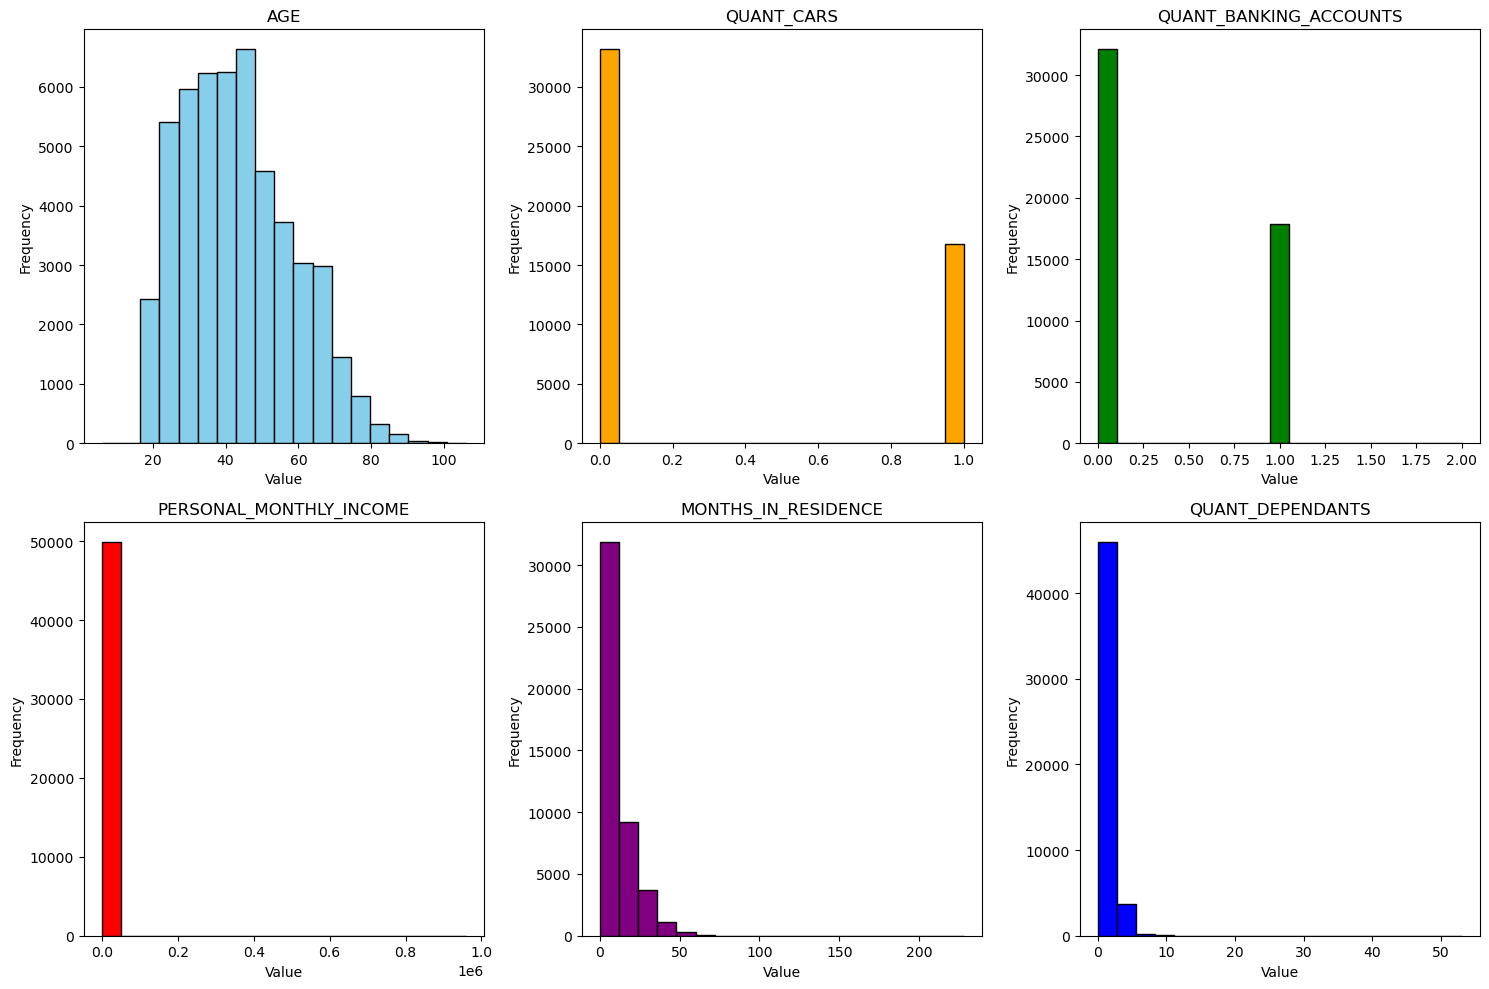

In [48]:
import matplotlib.pyplot as plt
import numpy as np


quant_vars = [
    "AGE",
    "QUANT_CARS",
    "QUANT_BANKING_ACCOUNTS",
    "PERSONAL_MONTHLY_INCOME",
    "MONTHS_IN_RESIDENCE",
    "QUANT_DEPENDANTS",
]

colors = ["skyblue", "orange", "green", "red", "purple", "blue"]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (column, color) in enumerate(zip(quant_vars, colors)):
    ax = axes[i]
    ax.hist(
        df1[column],
        bins=np.linspace(df1[column].min(), df1[column].max(), 20),
        color=color,
        edgecolor="black",
    )
    ax.set_title(column)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

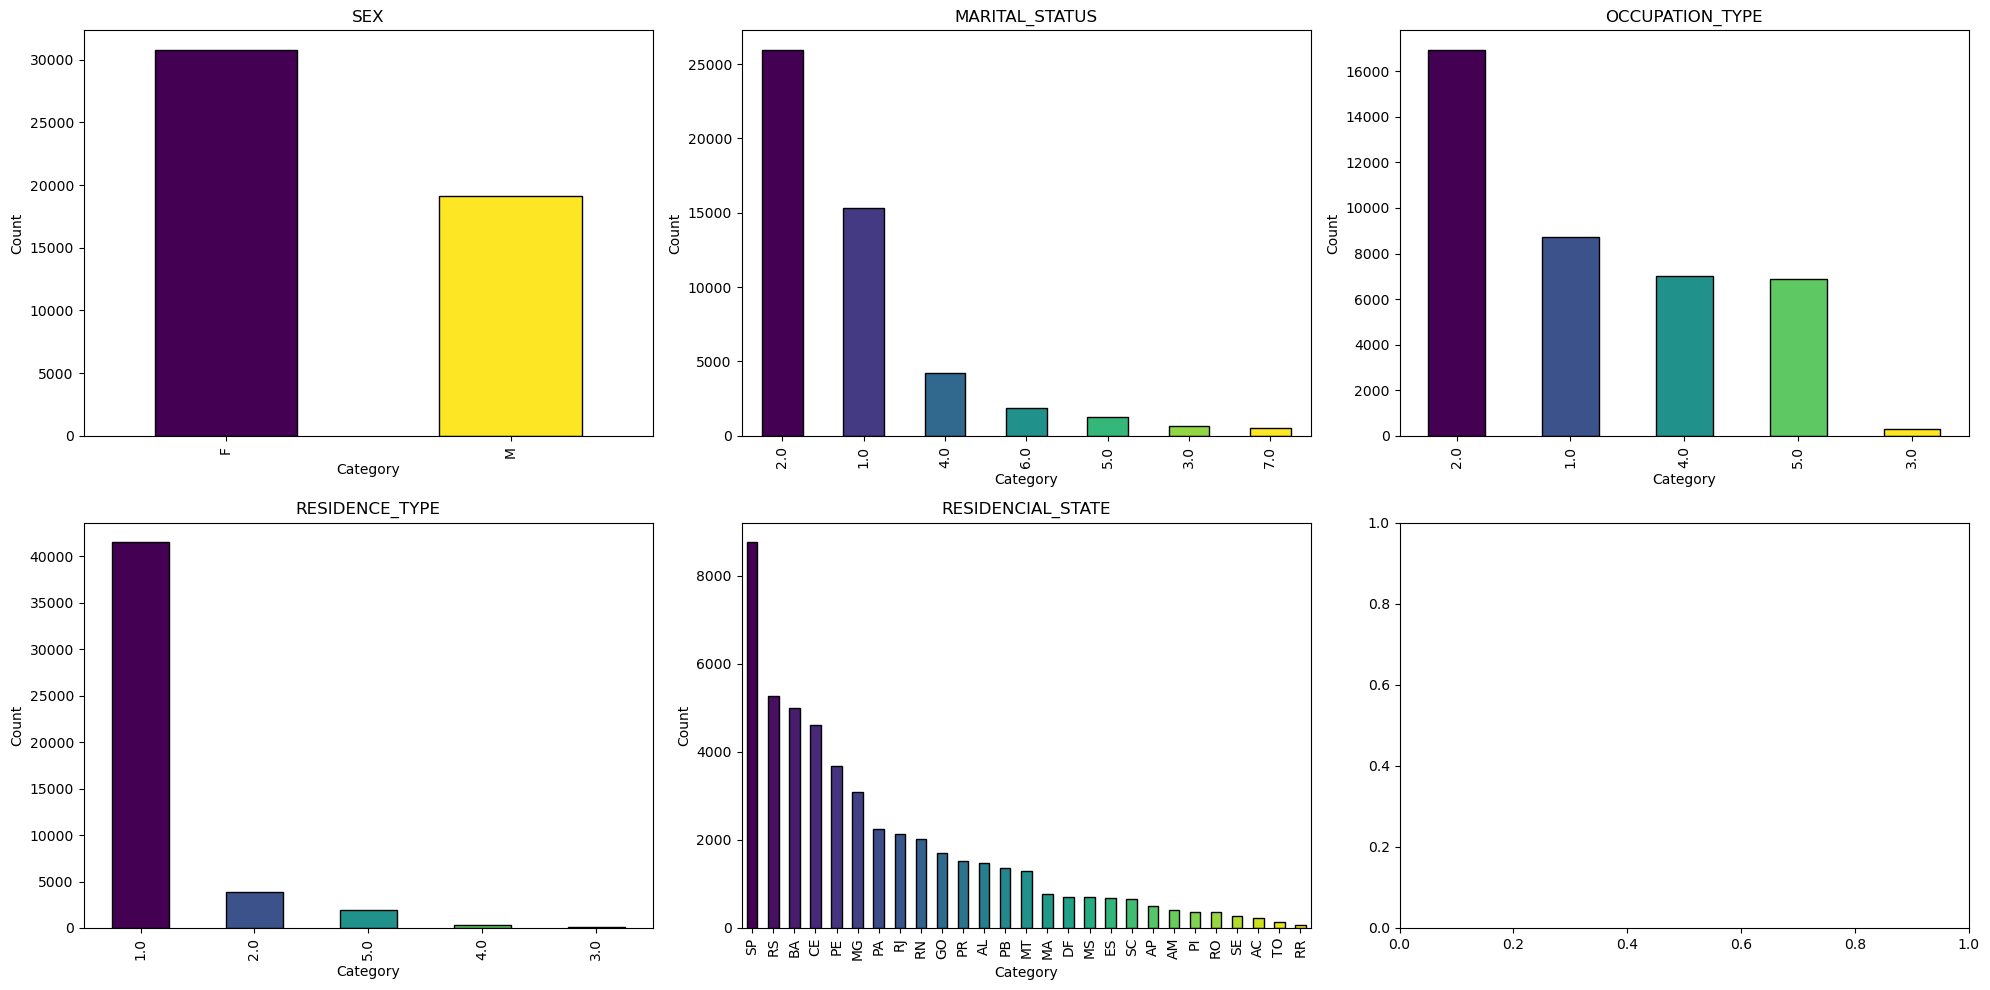

In [49]:
import matplotlib.pyplot as plt
import numpy as np

qual_vars2 = [
    "SEX",
    "MARITAL_STATUS",
    "OCCUPATION_TYPE",
    "RESIDENCE_TYPE",
    "RESIDENCIAL_STATE",
    # "RESIDENCIAL_BOROUGH",
]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

axes = axes.flatten()

cmap = plt.get_cmap("viridis")

for i, var in enumerate(qual_vars2):
    ax = axes[i]
    var_counts = df1[var].value_counts()
    categories = var_counts.index
    colors = cmap(np.linspace(0, 1, len(categories)))

    var_counts.plot(kind="bar", ax=ax, color=colors, edgecolor="black")
    ax.set_title(var)
    ax.set_xlabel("Category")
    ax.set_ylabel("Count")

plt.tight_layout()

plt.show()

In [50]:
# import matplotlib.pyplot as plt
#
# fig, axes = plt.subplots(5, 3, figsize=(15, 20))
# axes = axes.flatten()
#
# for i, column in enumerate(df1.columns):
#    axes[i].hist(df1[column].astype(str))
#    axes[i].set_title(column)
#
# plt.tight_layout()
# plt.show()

In [51]:
# Change to categorical variable
for i in ["MARITAL_STATUS", "OCCUPATION_TYPE", "RESIDENCE_TYPE"]:
    df1[i] = df1[i].astype("Int64").astype("category")

for i in ["SEX", "RESIDENCIAL_STATE", "RESIDENCIAL_CITY", "RESIDENCIAL_ZIP_3"]:
    df1[i] = df1[i].astype("category")

In [52]:
#  functional form of `PERSONAL_MONTHLY_INCOME` and `QUANT_DEPENDANTS`
df1["LOG_PERSONAL_MONTHLY_INCOME"] = df1["PERSONAL_MONTHLY_INCOME"].apply(
    lambda x: np.log(x + 1)
)

df1["LOG_MONTHS_IN_RESIDENCE"] = df1["MONTHS_IN_RESIDENCE"].apply(
    lambda x: np.log(x + 1)
)

# QUANT_DEPENDANTS
df1["QUANT_DEPENDANTS_BINARY"] = df1["QUANT_DEPENDANTS"].apply(
    lambda x: 1 if x > 2 else 0
)

In [53]:
df1.drop(columns=["PERSONAL_MONTHLY_INCOME", "MONTHS_IN_RESIDENCE"], inplace=True)

In [54]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   QUANT_DEPENDANTS             50000 non-null  int64   
 1   QUANT_CARS                   50000 non-null  int64   
 2   QUANT_BANKING_ACCOUNTS       50000 non-null  int64   
 3   AGE                          50000 non-null  int64   
 4   SEX                          49935 non-null  category
 5   MARITAL_STATUS               49798 non-null  category
 6   OCCUPATION_TYPE              39899 non-null  category
 7   RESIDENCE_TYPE               47891 non-null  category
 8   RESIDENCIAL_STATE            50000 non-null  category
 9   RESIDENCIAL_CITY             50000 non-null  category
 10  RESIDENCIAL_BOROUGH          50000 non-null  object  
 11  RESIDENCIAL_ZIP_3            49999 non-null  category
 12  TARGET_LABEL_BAD=1           50000 non-null  int64   
 13  L

### Exercise 4

Geographic segregation means residency data often contains LOTS of information. But there's a problem with `RESIDENCIAL_CITY` and `RESIDENCIAL_BOROUGH`. What is the problem?

In any real project, this would be something absolutely worth resolving, but for this exercise, we'll just drop all three string `RESIDENCIAL_` variables.

<Axes: >

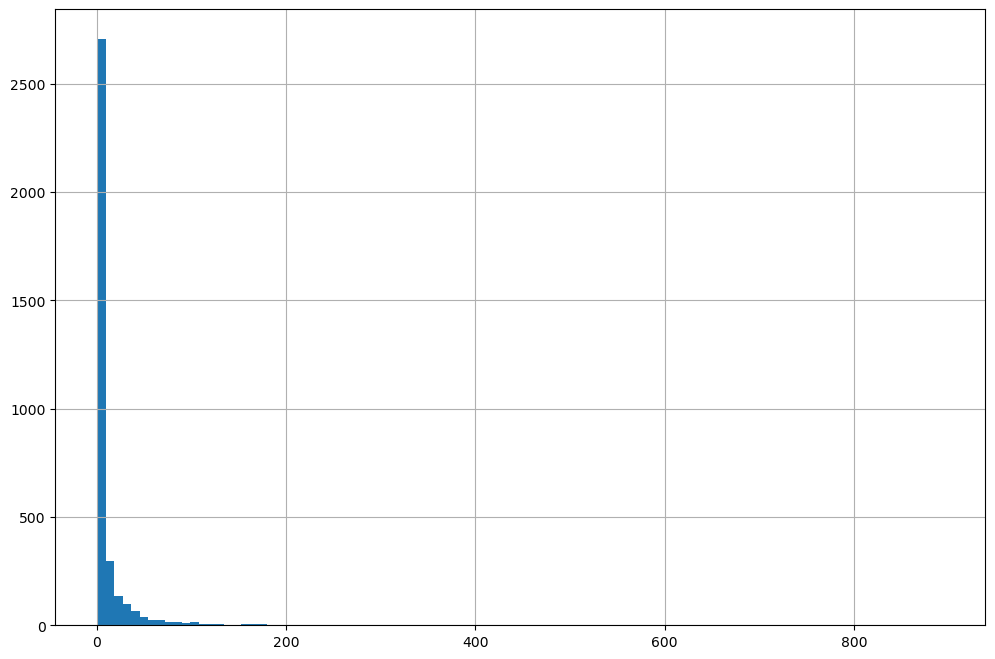

In [55]:
df1["RESIDENCIAL_CITY"].value_counts().hist(bins=100)

In [56]:
df1["RESIDENCIAL_CITY"].value_counts()

RESIDENCIAL_CITY
Sao Paulo        894
FORTALEZA        876
Fortaleza        714
MACEIO           651
PELOTAS          624
                ... 
MORADA NOPVA       1
MORADA N OVA       1
MONTENEGRO         1
MONTEIRO           1
volta redonda      1
Name: count, Length: 3529, dtype: int64

In [57]:
df1["RESIDENCIAL_BOROUGH"].value_counts()

RESIDENCIAL_BOROUGH
CENTRO                                   4169
Centro                                    425
ZONA RURAL                                372
centro                                    347
Fragata                                   237
                                         ... 
RUROPOLIS CAMELA                            1
MATIEL                                      1
NOVA CANAA                                  1
Jardim San Rerssore (Caucaia do alto)       1
jardim vida nova                            1
Name: count, Length: 14511, dtype: int64

In [58]:
qual_vars = [
    "SEX",
    "MARITAL_STATUS",
    "OCCUPATION_TYPE",
    "RESIDENCE_TYPE",
    "RESIDENCIAL_STATE",
    "RESIDENCIAL_CITY",
    "RESIDENCIAL_BOROUGH",
    "RESIDENCIAL_ZIP_3",
]

for column_name in qual_vars:
    total_unique = df1[column_name].nunique()
    print(
        f"Total number of unique observations in the '{column_name}' variable:",
        total_unique,
    )

Total number of unique observations in the 'SEX' variable: 2
Total number of unique observations in the 'MARITAL_STATUS' variable: 7
Total number of unique observations in the 'OCCUPATION_TYPE' variable: 5
Total number of unique observations in the 'RESIDENCE_TYPE' variable: 5
Total number of unique observations in the 'RESIDENCIAL_STATE' variable: 27
Total number of unique observations in the 'RESIDENCIAL_CITY' variable: 3529
Total number of unique observations in the 'RESIDENCIAL_BOROUGH' variable: 14511
Total number of unique observations in the 'RESIDENCIAL_ZIP_3' variable: 1480


> The total number of unique observations in the 'RESIDENCIAL_CITY' is 3529, and for 'RESIDENCIAL_BOROUGH' is 14511. By doing a review of these unique values, we can see that most of them point to the same borough but with different spelling, use of caps or use of complete name. These lack of consistency on spelling results in different observations in the dataset that refer to the same city or borough. 

In [59]:
# drop RESIDENCIAL_ variable
new_df = df1.filter(regex=r"^(?!RESIDENCIAL_).*")
# new_df

In [60]:
new_df.columns

Index(['QUANT_DEPENDANTS', 'QUANT_CARS', 'QUANT_BANKING_ACCOUNTS', 'AGE',
       'SEX', 'MARITAL_STATUS', 'OCCUPATION_TYPE', 'RESIDENCE_TYPE',
       'TARGET_LABEL_BAD=1', 'LOG_PERSONAL_MONTHLY_INCOME',
       'LOG_MONTHS_IN_RESIDENCE', 'QUANT_DEPENDANTS_BINARY'],
      dtype='object')

In [61]:
# drop missing values
new_df = new_df.drop(columns="QUANT_DEPENDANTS").dropna()

In [62]:
# solve categorical data
for var in [
    "QUANT_CARS",
    "QUANT_BANKING_ACCOUNTS",
    "QUANT_DEPENDANTS_BINARY",
]:
    new_df[var] = new_df[var].astype("category")


categorical_variables = [
    "QUANT_CARS",
    "QUANT_BANKING_ACCOUNTS",
    "SEX",
    "MARITAL_STATUS",
    "OCCUPATION_TYPE",
    "RESIDENCE_TYPE",
    "QUANT_DEPENDANTS_BINARY",
]

for var in categorical_variables:
    new_df[var] = new_df[var].cat.codes

In [63]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36999 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   QUANT_CARS                   36999 non-null  int8   
 1   QUANT_BANKING_ACCOUNTS       36999 non-null  int8   
 2   AGE                          36999 non-null  int64  
 3   SEX                          36999 non-null  int8   
 4   MARITAL_STATUS               36999 non-null  int8   
 5   OCCUPATION_TYPE              36999 non-null  int8   
 6   RESIDENCE_TYPE               36999 non-null  int8   
 7   TARGET_LABEL_BAD=1           36999 non-null  int64  
 8   LOG_PERSONAL_MONTHLY_INCOME  36999 non-null  float64
 9   LOG_MONTHS_IN_RESIDENCE      36999 non-null  float64
 10  QUANT_DEPENDANTS_BINARY      36999 non-null  int8   
dtypes: float64(2), int64(2), int8(7)
memory usage: 1.7 MB


## Model Fitting

### Exercise 5

First, use `train_test_split` to do an 80/20 split of your data. Then, using the `TARGET_LABEL_BAD` variable, fit a classification model on this data. Optimize with `gridsearch`. Use splines for continuous variables and factors for categoricals.

At this point we'd *ideally* be working with 11 variables. However pyGAM can get a little slow with factor features with lots of values + lots of unique values (e.g., 50,000 observations and the *many* values of `RESIDENCIAL_ZIP` takes about 15 minutes on my computer). In that configuration, you should get a model fit in 10-15 seconds.

So let's start by fitting a model that also excludes `RESIDENCIAL_ZIP`.

In [64]:
# Train test split\
X = new_df.loc[:, new_df.columns != "TARGET_LABEL_BAD=1"]
y = new_df["TARGET_LABEL_BAD=1"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [65]:
X_train_arr = X_train.to_numpy()
y_train_arr = y_train.to_numpy()

# lambdas
lams = np.logspace(-3, 3, 4)

gam = LogisticGAM(f(0) + f(1) + s(2) + f(3) + f(4) + f(5) + f(6) + s(7) + s(8) + f(9))
gam.gridsearch(X_train_arr, y_train_arr, lam=lams)

  0% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:01 ETA:   0:00:04
 50% (2 of 4) |#############             | Elapsed Time: 0:00:02 ETA:   0:00:02
 75% (3 of 4) |###################       | Elapsed Time: 0:00:03 ETA:   0:00:01
100% (4 of 4) |##########################| Elapsed Time: 0:00:04 Time:  0:00:04


LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=f(0) + f(1) + s(2) + f(3) + f(4) + f(5) + f(6) + s(7) + s(8) + f(9) + intercept,
   tol=0.0001, verbose=False)

In [66]:
print("The best lambda (grid search) is:")
print(gam.lam[0][0])

The best lambda (grid search) is:
10.0


In [67]:
y_pred = gam.predict(X_test.to_numpy())
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7404054054054054


### Exercise 6

Create a (naive) confusion matrix using the predicted values you get with `predict()` on your test data. Our stakeholder cares about two things: 

- maximizing the number of people to whom they extend credit, and
- the false negative rate (the share of people identified as "safe bets" who aren't, and who thus default).

How many "good bets" does the model predict (true negatives), and what is the [False Omission Rate](https://en.wikipedia.org/wiki/False_omission_rate) (the share of predicted negatives that are false negatives)?

Looking at the confusion matrix, how did the model maximize accuracy?

In [68]:
def cm_for(y_test, y_pred, process=True):
    ConfuMat = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = ConfuMat.ravel()
    FOR = FN / (FN + TN) if (FN + TN) > 0 else 0
    if process:
        print(f"TN, FP, FN, TP: {TN, FP, FN, TP}")
        print(f"False Omission Rate: {FOR} ")

    return (TN, FP, FN, TP), FOR

In [69]:
col, FOR = cm_for(y_test, y_pred)

TN, FP, FN, TP: (5474, 1, 1920, 5)
False Omission Rate: 0.2596700027048959 


> There are 5474 "good bets" or True Negatives (people who would not default and thus we would extend credit)

> The False Omission Rate, or predicted negatives that are false negatives, is around 0.2597. Thus the proportion that were 'safe' bets but that would default over all the predicted negatives. 

> The model maximizes the accuracy through predicting more people who would not default and minimizing the false positives. In the training set, there are more people who would not default (TN+FN=5474+1920=7394)than would default, so the model predicts more majority class in the testing period and less minority class (7394 vs. 6).

### Exercise 7

Suppose your stakeholder wants to minimize false negative rates. How low of a [False Omission Rate](https://en.wikipedia.org/wiki/False_omission_rate) (the share of predicted negatives that are false negatives) can you get (assuming more than, say, 10 true negatives), and how many "good bets" (true negatives) do they get at that risk level?

Hint: use `predict_proba()`

Note: One *can* use class weights to shift the emphasis of the original model fitting, but for the moment let's just play with `predict_proba()` and thresholds.

In [70]:
# predict probability
y_prob = gam.predict_proba(X_test)

# Find the best threshold to minimize FOR and maximize Good Bets
# from 0% to 100%
thre_range = np.linspace(0, 1, 101)
GB = []
FORS = []

for thre in thre_range:
    y_pred_thre = (y_prob > thre).astype("int")

    (TN, FP, FN, TP), FOR = cm_for(y_test, y_pred_thre, process=False)

    GB.append(TN)
    FORS.append(FOR)

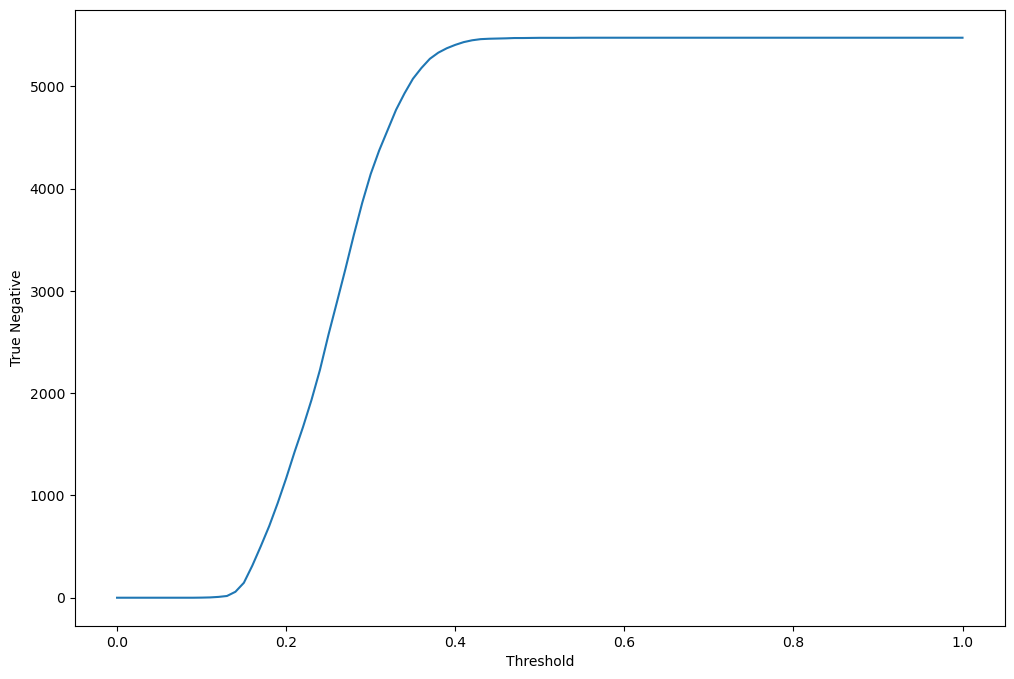

In [71]:
# good bets
plt.plot(thre_range, GB)
plt.xlabel("Threshold")
plt.ylabel("True Negative")
plt.show()

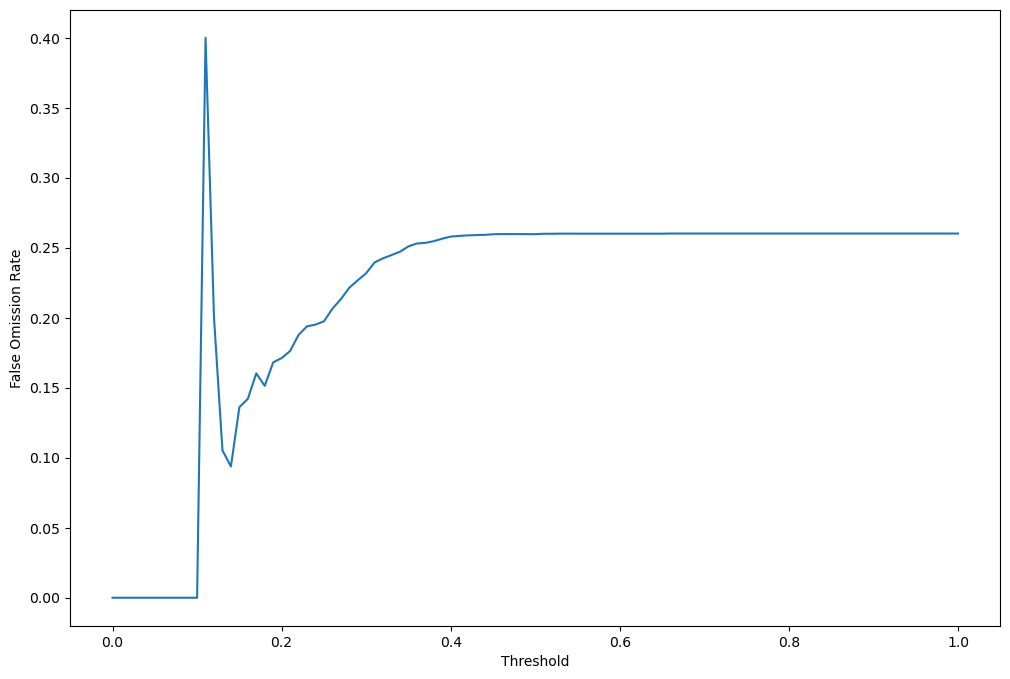

In [72]:
plt.plot(thre_range, FORS)
plt.xlabel("Threshold")
plt.ylabel("False Omission Rate")
plt.show()

In [73]:
# Find min FOR and corresponding good bets
min_FOR = min(x for x in FORS if x > 0.0)

min_indices = [i for i, x in enumerate(FORS) if x == min_FOR]

corresponding_GB = [GB[i] for i in min_indices]

print(f"Best threshold: {thre_range[min_indices][0]}")
print(f"Minimum FOR: {min_FOR}")
print(f"Corresponding GB values: {corresponding_GB[0]}")

Best threshold: 0.14
Minimum FOR: 0.09375
Corresponding GB values: 58


> We can minimize the False Omission Rate through changing the threshold value, the best threshold is 0.14. 
> According to the result, the minimum False Omission Rate is 0.09375, where the corresponding "good bets" or True Negatives is 58. 

### Exercise 8

If the stakeholder wants to maximize true negatives and can tolerate a false omission rate of 19%, how many true negatives will they be able to enroll?

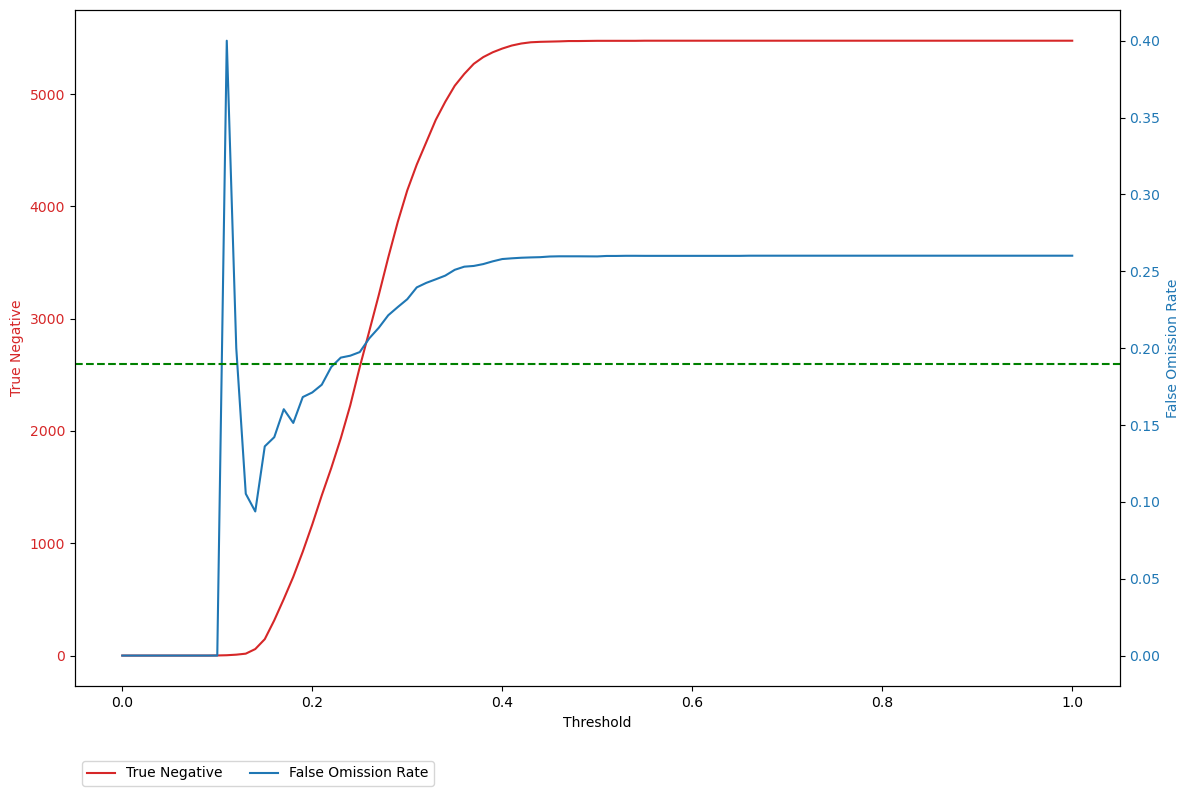

In [74]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("Threshold")
ax1.set_ylabel("True Negative", color=color)
ax1.plot(thre_range, GB, color=color, label="True Negative")
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_ylabel("False Omission Rate", color=color)
ax2.plot(thre_range, FORS, color=color, label="False Omission Rate")
ax2.tick_params(axis="y", labelcolor=color)
ax2.axhline(y=0.19, color="green", linestyle="--")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(
    lines + lines2, labels + labels2, loc="upper left", bbox_to_anchor=(0, -0.1), ncol=3
)

fig.tight_layout()
plt.show()

In [75]:
sele_FOR = [x for x in FORS if x > 0.0 and x < 0.19]

sele_indices = [i for i, x in enumerate(FORS) if x in sele_FOR]

sele_corresponding_GB = [GB[i] for i in sele_indices]

max_sele_gb = max(sele_corresponding_GB)

In [76]:
print(f"The max true negatives needed to be enrolled: {max_sele_gb}")

The max true negatives needed to be enrolled: 1670


## Let's See This Interpretability!

We're using GAMs for their interpretability, so let's use it!

### Exercise 9


Plot the partial dependence plots for all your continuous factors with 95% confidence intervals (I have three, at this stage).

If you get an error like this when generating `partial_dependence` errors:

```python
----> pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

...
ValueError: X data is out of domain for categorical feature 4. Expected data on [1.0, 2.0], but found data on [0.0, 0.0]
```

it's because you have a variable set as a factor that doesn't have values of `0`. pyGAM is assuming `0` is the excluded category. Just recode the variable to ensure 0 is used to identify one of the categories.

In [77]:
# check continuous variables
# new_df.info()

# for column in new_df.columns:
#     unique_values = new_df[column].unique()
#     print(f"Column: {column}")
#     print(f"Unique Values: {unique_values}")
#     print()

# continuous (float)
cont_vars = {"AGE": 2, "PERSONAL_MONTHLY_INCOME_LOG": 7, "MONTHS_IN_RESIDENCE_LOG": 8}

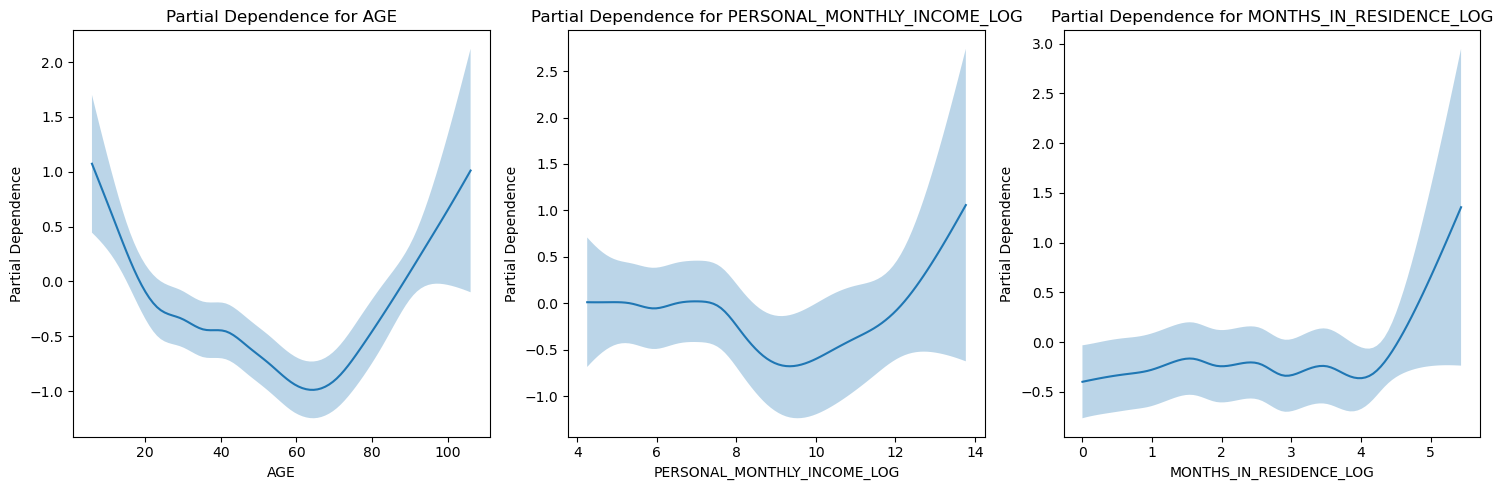

In [78]:
# Plot the partial dependence plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for ax, (feature, i) in zip(axs, cont_vars.items()):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    ax.plot(XX[:, i], pdep)
    ax.fill_between(XX[:, i], confi[:, 0], confi[:, 1], alpha=0.3)
    ax.set_xlabel(feature)
    ax.set_ylabel("Partial Dependence")
    ax.set_title(f"Partial Dependence for {feature}")

plt.tight_layout()
plt.show()

### Exercise 10

How does the partial correlation with respect to age look?

> Based on the plot of the partial dependence of age, we can find that the partial correlation is "U-shape". It reveals that as the age increase, the likelihood of default decreases. At the age around 65, the result reaches the lowest likelihood to default. After reaching 65, the trend reverses, and the likelihood of default starts to increase with further increases in age. 

### Exercise 11

Refit your model, but this time impose [monotonicity or concavity/convexity](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Penalties-/-Constraints) on the relationship between age and credit risk (which makes more sense to you?). Fit the model and plot the new partial dependence.

> According to the "U-shape" curve, we should use concavity.

In [79]:
# fit the new model
gam_1 = LogisticGAM(
    f(0)
    + f(1)
    + s(2, constraints="concave")
    + f(3)
    + f(4)
    + f(5)
    + f(6)
    + s(7)
    + s(8)
    + f(9)
)
gam_1.gridsearch(X_train_arr, y_train_arr, lam=lams)

  0% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:01 ETA:   0:00:05
 50% (2 of 4) |#############             | Elapsed Time: 0:00:03 ETA:   0:00:03
 75% (3 of 4) |###################       | Elapsed Time: 0:00:04 ETA:   0:00:01
100% (4 of 4) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05


LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=f(0) + f(1) + s(2) + f(3) + f(4) + f(5) + f(6) + s(7) + s(8) + f(9) + intercept,
   tol=0.0001, verbose=False)

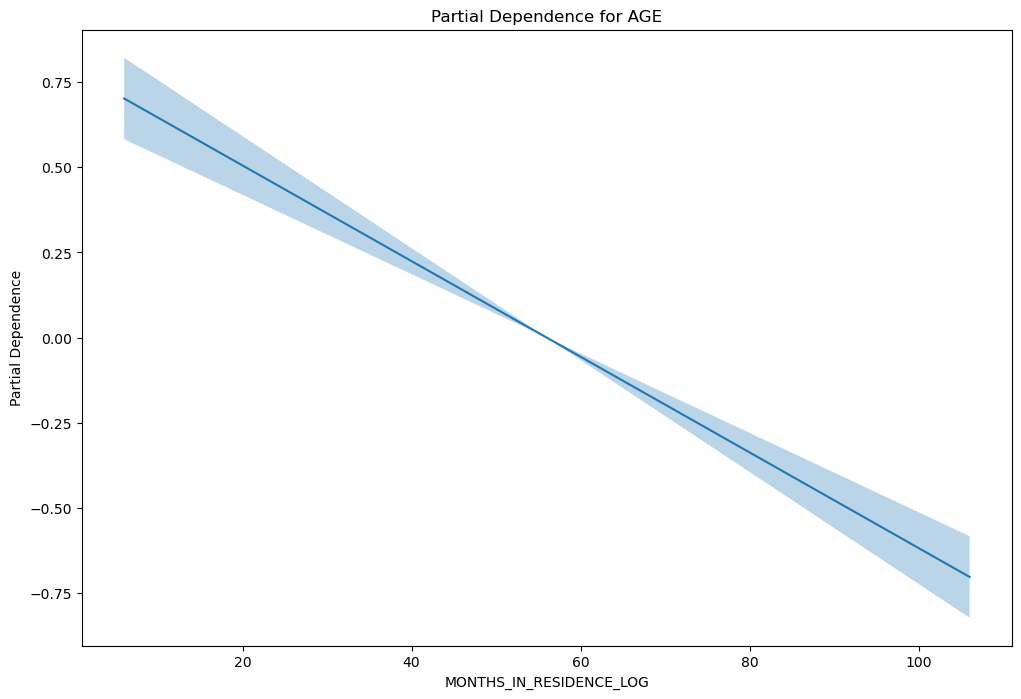

In [80]:
XX = gam.generate_X_grid(term=2)
pdep, confi = gam_1.partial_dependence(term=2, X=XX, width=0.95)
plt.plot(XX[:, 2], pdep)
plt.fill_between(XX[:, 2], confi[:, 0], confi[:, 1], alpha=0.3)
plt.xlabel(feature)
plt.ylabel("Partial Dependence")
plt.title(f"Partial Dependence for AGE")
plt.show()

### Exercise 12

Functional form constraints are often about fairness or meeting regulatory requirements, but they can also prevent overfitting.

Does this change the number of "true negatives" you can enroll below a false omission rate of 19%?

In [81]:
# predict
y_prob1 = gam_1.predict_proba(X_test)

# Find the best threshold to minimize FOR and maximize Good Bets
# from 0% to 100%
thre_range = np.linspace(0, 1, 101)
GB1 = []
FORS1 = []

for thre in thre_range:
    y_pred_thre = (y_prob1 > thre).astype("int")

    (TN, FP, FN, TP), FOR = cm_for(y_test, y_pred_thre, process=False)

    GB1.append(TN)
    FORS1.append(FOR)

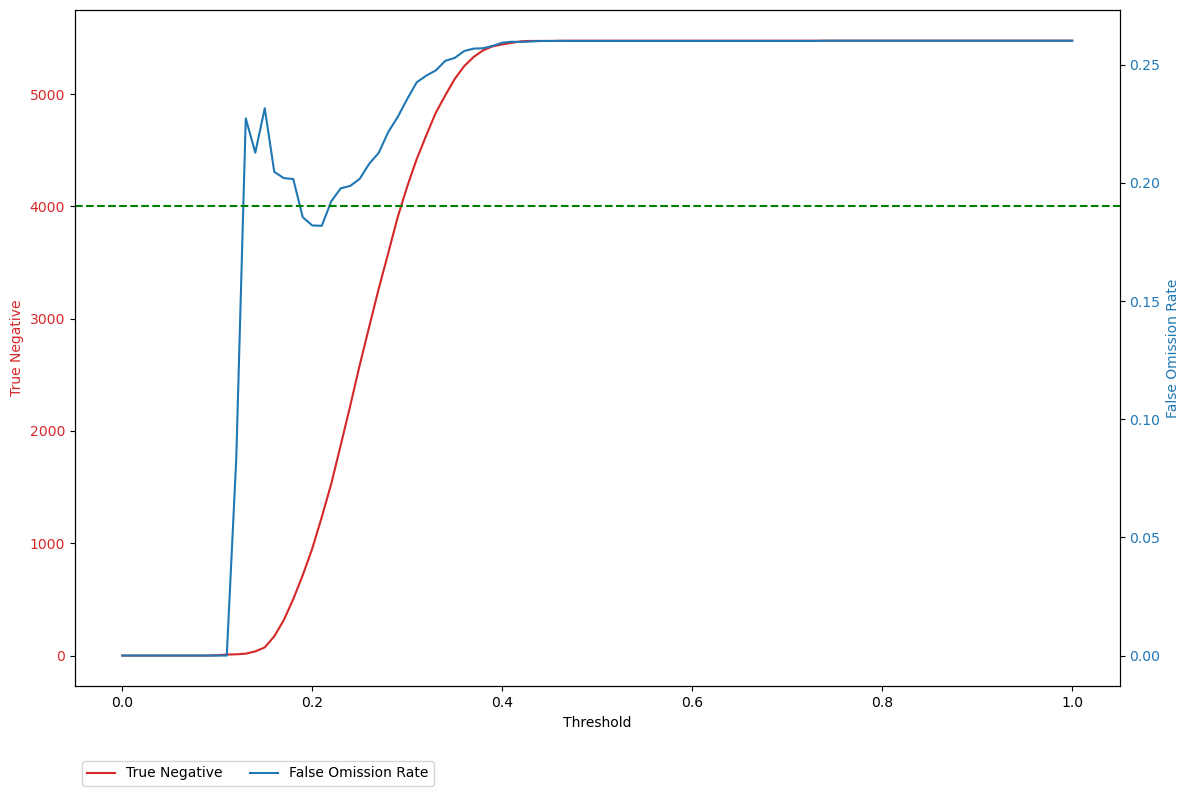

In [82]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("Threshold")
ax1.set_ylabel("True Negative", color=color)
ax1.plot(thre_range, GB1, color=color, label="True Negative")
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_ylabel("False Omission Rate", color=color)
ax2.plot(thre_range, FORS1, color=color, label="False Omission Rate")
ax2.tick_params(axis="y", labelcolor=color)
ax2.axhline(y=0.19, color="green", linestyle="--")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(
    lines + lines2, labels + labels2, loc="upper left", bbox_to_anchor=(0, -0.1), ncol=3
)

fig.tight_layout()
plt.show()

In [83]:
sele_FOR1 = [x for x in FORS1 if x > 0.0 and x < 0.19]

sele_indices1 = [i for i, x in enumerate(FORS1) if x in sele_FOR1]

sele_corresponding_GB1 = [GB1[i] for i in sele_indices1]

max_sele_gb1 = max(sele_corresponding_GB1)

print(f"The max true negatives needed to be enrolled: {max_sele_gb1}")

The max true negatives needed to be enrolled: 1233


> Yes. The number of "true negatives" we can enrolled with below 19% changes from 1670 to 1233.

### Exercise 13

In the preceding exercises, we allowed pyGAM to choose its own smoothing parameters / coefficient penalties. This makes life easy, but it isn't always optimal, especially because when it does so, it picks the same smoothing penalty (the `lambda` in `.summary()`) for all terms.

(If you haven't seen them let, penalities are designed to limit overfitting by, basically, "penalizing" big coefficients on different terms. This tends to push models towards smoother fits.)

[To get around this, we can do a grid or random search.](https://pygam.readthedocs.io/en/latest/notebooks/quick_start.html#Automatically-tune-the-model) This is definitely a little slow, but let's give it a try!

Then following the model given in the docs linked above, let's do a random search. Make sure your initial random points has a shape of `100 x (the number of terms in your model)`.

In [84]:
# 10 terms
num_terms = 10
init_lams = 10 ** (np.random.rand(100, num_terms) * 6 - 3)

In [85]:
# modeling
loggam = LogisticGAM(
    f(0) + f(1) + s(2) + f(3) + f(4) + f(5) + f(6) + s(7) + s(8) + f(9)
).gridsearch(X_train_arr, y_train_arr, lam=init_lams)

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:51
  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:39
  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:29
  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:26
  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:24
  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:22
  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:18
  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:15
  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:17
 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:15
 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:14
 12% (12 of 100) |##                    

In [86]:
# model summary
loggam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     31.8153
Link Function:                        LogitLink Log Likelihood:                                 -16635.201
Number of Samples:                        29599 AIC:                                            33334.0327
                                                AICc:                                           33334.1078
                                                UBRE:                                                3.127
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0182
Feature Function                  Lam

### Exercise 14

How many true negatives can you get now at a less than 19% False Omission Rate?

In [87]:
def find_tn(model, X_test, threshold):
    y_prob1 = model.predict_proba(X_test)
    thre_range = np.linspace(0, 1, 101)
    GB1 = []
    FORS1 = []

    for thre in thre_range:
        y_pred_thre = (y_prob1 > thre).astype("int")
        (TN, FP, FN, TP), FOR = cm_for(y_test, y_pred_thre, process=False)
        GB1.append(TN)
        FORS1.append(FOR)

    sele_FOR1 = [x for x in FORS1 if x > 0.0 and x < threshold]
    sele_indices1 = [i for i, x in enumerate(FORS1) if x in sele_FOR1]
    sele_corresponding_GB1 = [GB1[i] for i in sele_indices1]
    max_sele_gb1 = max(sele_corresponding_GB1)
    print(f"The max true negatives needed to be enrolled: {max_sele_gb1}")

In [88]:
find_tn(loggam, X_test, 0.19)

The max true negatives needed to be enrolled: 1684


### Exercise 15

Add an interaction term between age and personal income.

In [89]:
from pygam import LogisticGAM, s, te

# 10 terms
num_terms = 10
init_lams = 10 ** (np.random.rand(100, num_terms) * 6 - 3)


# fit interaction
gam_2 = LogisticGAM(f(0) + f(1) + te(2, 7) + f(3) + f(4) + f(5) + f(6) + s(8) + f(9))
gam_2.gridsearch(X_train_arr, y_train_arr, lam=init_lams)

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  1% (1 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:03:29
  2% (2 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:02:53
  3% (3 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:02:32
  4% (4 of 100) |                        | Elapsed Time: 0:00:06 ETA:   0:02:45
  5% (5 of 100) |#                       | Elapsed Time: 0:00:08 ETA:   0:02:44
  6% (6 of 100) |#                       | Elapsed Time: 0:00:10 ETA:   0:02:39
  7% (7 of 100) |#                       | Elapsed Time: 0:00:11 ETA:   0:02:37
  8% (8 of 100) |#                       | Elapsed Time: 0:00:13 ETA:   0:02:31
  9% (9 of 100) |##                      | Elapsed Time: 0:00:15 ETA:   0:02:34
 10% (10 of 100) |##                     | Elapsed Time: 0:00:16 ETA:   0:02:31
 11% (11 of 100) |##                     | Elapsed Time: 0:00:18 ETA:   0:02:27
 12% (12 of 100) |##                    

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=f(0) + f(1) + te(2, 7) + f(3) + f(4) + f(5) + f(6) + s(8) + f(9) + intercept,
   tol=0.0001, verbose=False)

In [90]:
# model summary
gam_2.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     38.0373
Link Function:                        LogitLink Log Likelihood:                                -16616.0508
Number of Samples:                        29599 AIC:                                             33308.176
                                                AICc:                                           33308.2818
                                                UBRE:                                               3.1263
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0194
Feature Function                  Lam

### Exercise 16

Now visualize the [partial dependence interaction term.](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Terms-and-Interactions)

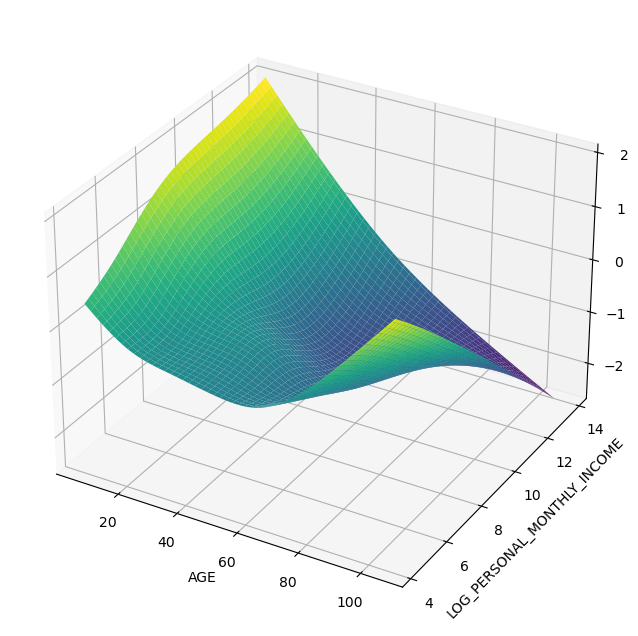

In [91]:
plt.rcParams["figure.figsize"] = (12, 8)
XX = gam_2.generate_X_grid(term=2, meshgrid=True)
Z = gam_2.partial_dependence(term=2, X=XX, meshgrid=True)
ax = plt.axes(projection="3d")
ax.plot_surface(XX[0], XX[1], Z, cmap="viridis")
ax.set_ylabel("LOG_PERSONAL_MONTHLY_INCOME")
ax.set_zlabel("Partial Dependence")
ax.set_xlabel("AGE")
plt.show()

### Exercise 17

Finally, another popular interpretable model is the `ExplainableBoostingClassifier`. You can learn more [about it here](https://interpret.ml/docs/ebm.html), though how much sense it will make to you may be limited if you aren't familiar with gradient boosting yet. Still, at least one of your classmates prefers it to pyGAM, so give it a try using this code:


```python
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
import warnings

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

with warnings.catch_warnings():
   warnings.simplefilter("ignore")

   ebm_global = ebm.explain_global()
   show(ebm_global)

   ebm_local = ebm.explain_local(X_train, y_train)
   show(ebm_local)
```

In [92]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
import warnings

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    ebm_global = ebm.explain_global()
    show(ebm_global)

    ebm_local = ebm.explain_local(X_train, y_train)
    show(ebm_local)

<!-- http://127.0.0.1:7001/11185980560/ -->

<!-- http://127.0.0.1:7001/11544527888/ -->